Code is based loosely off of another classic computer vision program: [pip install opencv-python numpy matplotlib scikit-learn imutils](https://pyimagesearch.com/2017/02/13/recognizing-digits-with-opencv-and-python/)

First we must import all necessary libraries

In [117]:
# starting venv
# .\cvvenv\Scripts\activate

# imports
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np

First we define the dictionary of note positions so we can identify each note below, on, and above the staff

Eventually, we hope to get an array extracted from an image that we can compare with our dictionary

Addendum: I later went with a different method of identifying notes as that felt more intuitive but this dictionary was integral to setting up my thought process of approaching this project

In [118]:
below = 0
staff = 0
above = 0
LINE = 1
SPACE = 2

NOTES_LOOKUP = {
    (LINE, below, staff, staff, staff, staff, staff, above, above): "C_low",
    (SPACE, below, staff, staff, staff, staff, staff, above, above): "D_low",
    (below, LINE, staff, staff, staff, staff, staff, above, above): "E_low",
    (below, SPACE, staff, staff, staff, staff, staff, above, above): "F_low",

    (below, below, LINE, staff, staff, staff, staff, above, above): "G_low",
    (below, below, SPACE, staff, staff, staff, staff, above, above): "A_mid",
    (below, below, staff, LINE, staff, staff, staff, above, above): "B_mid",
    (below, below, staff, SPACE, staff, staff, staff, above, above): "C_mid",
    (below, below, staff, staff, LINE, staff, staff, above, above): "D_mid",
    (below, below, staff, staff, SPACE, staff, staff, above, above): "E_mid",    
    (below, below, staff, staff, staff, LINE, staff, above, above): "F_mid",
    (below, below, staff, staff, staff, SPACE, staff, above, above): "G_mid",
    (below, below, staff, staff, staff, staff, LINE, above, above): "A_high",
    (below, below, staff, staff, staff, staff, SPACE, above, above): "B_high",
      
    (below, below, staff, staff, staff, staff, staff, LINE, above): "C_high",
    (below, below, staff, staff, staff, staff, staff, SPACE, above): "D_high",
    (below, below, staff, staff, staff, staff, staff, above, LINE): "E_high",
    (below, below, staff, staff, staff, staff, staff, above, SPACE): "F_high" 

}

Let's load an example image and conduct some preprocessing

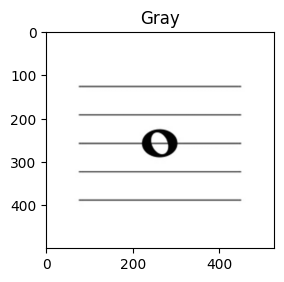

In [119]:
image = cv2.imread("example.jpg")

image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1), plt.imshow(gray, cmap='gray'), plt.title("Gray")
plt.show()

Now we want to draw a bounding box around the single note and all staff lines including ledgers if applicable

For reference: this is how we will identify our staff lines which are just horizontal lines: https://stackoverflow.com/questions/7227074/horizontal-line-detection-with-opencv

In [120]:
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
result = image.copy()

# line detection
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
line_cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
line_cnts = line_cnts[0] if len(line_cnts) == 2 else line_cnts[1]
for c in line_cnts:
    cv2.drawContours(result, [c], -1, (36,255,12), 2)

cv2.imshow('result', result)
cv2.waitKey()

-1

Sort lines by top to bottom

In [121]:
staff_lines = []

# gets the 5 widest lines
line_counter = 1
for c in line_cnts:
    # get bounding box for each individual cnts and append
    x, y, w, h = cv2.boundingRect(c)
    staff_lines.append(("line " + str(line_counter), y))
    line_counter += 1

# top to bottom
staff_lines.sort(key=lambda item: item[1])
print(staff_lines)

[('line 5', 126), ('line 4', 192), ('line 3', 257), ('line 2', 323), ('line 1', 388)]


Now that we have the lines and their y-axis we can now find the note head

In [ ]:
removed_lines = cv2.subtract(thresh, detect_horizontal)

just_head = cv2.dilate(removed_lines, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15)))
contours = cv2.findContours(just_head, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

note_head = max(contours, key=cv2.contourArea)

result = image.copy()

x, y, w, h = cv2.boundingRect(note_head)
note_center = y + h/2
note_top = y
note_bottom = y + h

top_left = (x, y)
bottom_right = (x+w, y+h)
green = (0, 255, 0)

# https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
cv2.rectangle(result, top_left, bottom_right, green, 2)

note_with_staff = image[y:y+h, x:x+w]

cv2.imshow("result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

Now that we have the staff lines and the note head detected, we can run comparison 

In [125]:
# print(staff_lines)
# print(note_center)

intersection_list = []

line_note = False
space_note = False

for line in staff_lines:
    min_threshhold = note_center - 5
    max_threshhold = note_center + 5
    if max_threshhold >= line[1] >= min_threshhold:
        line_note = True
        intersection_list.append(line[0])
        break

# if not a line note, see if it's a space note
if line_note == False:
    for i in range(len(staff_lines)-1):
        min_top_threshhold = note_top - 5
        max_top_threshhold = note_top + 5
        min_bottom_threshhold = note_bottom - 5
        max_bottom_threshhold = note_bottom + 5
        top_line_analysis = max_top_threshhold >= line[i] >= min_top_threshhold  
        bottom_line_analysis = min_bottom_threshhold >= line[i+1] >= min_top_threshhold      
        if (top_line_analysis == True) and (bottom_line_analysis):
            line_note = True
            intersection_list.append(line[i])
            intersection_list.append(line[i+1])
            break

# note is on a line
if line_note == True:
    if "line 1" in intersection_list:
        print("Note: A")
    if "line 2" in intersection_list:
        print("Note: F")
    if "line 3" in intersection_list:
        print("Note: D")
    if "line 4" in intersection_list:
        print("Note: B")
    if "line 5" in intersection_list:
        print("Note: G")

# note is in a space
if line_note == False:
    if ("line 1" in intersection_list) and ("line 2" in intersection_list):
        print("Note: G")
    if ("line 2" in intersection_list) and ("line 3" in intersection_list):
        print("Note: E")
    if ("line 3" in intersection_list) and ("line 4" in intersection_list):
        print("Note: C")
    if ("line 4" in intersection_list) and ("line 5" in intersection_list):
        print("Note: A")

Note: D
